In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

## Import Team Data

In [2]:
train_home_team_statistics_df = pd.read_csv('/kaggle/input/football-challenge/train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv('/kaggle/input/football-challenge/train_away_team_statistics_df.csv', index_col=0)


train_home_player_statistics_df = pd.read_csv('/kaggle/input/football-challenge/train_home_player_statistics_df.csv', index_col=0)
train_away_player_statistics_df = pd.read_csv('/kaggle/input/football-challenge/train_away_player_statistics_df.csv', index_col=0)

train_scores = pd.read_csv('/kaggle/input/football-challenge/Y_train.csv', index_col=0)

In [3]:
test_home_team_statistics_df = pd.read_csv('/kaggle/input/football-challenge/test_home_team_statistics_df.csv', index_col=0)
test_away_team_statistics_df = pd.read_csv('/kaggle/input/football-challenge/test_away_team_statistics_df.csv', index_col=0)


test_home_player_statistics_df = pd.read_csv('/kaggle/input/football-challenge/test_home_player_statistics_df.csv', index_col=0)
test_away_player_statistics_df = pd.read_csv('/kaggle/input/football-challenge/test_away_player_statistics_df.csv', index_col=0)

# Fill Nan Teams

## On peut remarquer que si on ordonne deux variables dans un ordre croissant, les autre variables et grace à leurs dépendaces suivront une tendance gégénérale qui est croissante

In [4]:
import pandas as pd

def fill_na_function(df):
    # Identifying columns with NaN values
    nan_col = [column for column in df.columns if df[column].isna().any()]
    
    # Loop through each team
    for team in df['TEAM_NAME'].unique():
        team_df = df[df['TEAM_NAME'] == team].sort_values(by=["TEAM_SHOTS_TOTAL_season_sum", "TEAM_SHOTS_INSIDEBOX_season_sum"])
        
        # Apply forward and backward fill within each team's DataFrame
        for col in nan_col:
            ff = team_df[col].fillna(method='ffill')
            fb = team_df[col].fillna(method='bfill')
            team_df[col] = (ff + fb) / 2
           # Then, if there are still NaN values, fill them with the column's mean
            if team_df[col].isna().any():
                mean_value = team_df[col].mean()
                team_df[col] = team_df[col].fillna(mean_value)
                
            if team_df[col].isna().any():
                     team_df[col] = team_df[col].fillna(0)
            
        
        # Update the original DataFrame with filled values
        df.update(team_df)
    
    # Recheck for any remaining NaNs
    recheck = [column for column in df.columns if df[column].isna().any()]
    if len(recheck) == 0:
        print("All NaNs cleaned!")
    else:
        print(f"There are {len(recheck)} columns not cleaned!")
    
    return df

# Assuming `train_home_team_statistics_df` is defined
train_home = fill_na_function(train_home_team_statistics_df)
train_away = fill_na_function(train_away_team_statistics_df)

All NaNs cleaned!
All NaNs cleaned!


In [5]:
test_home = test_home_team_statistics_df.fillna(test_home_team_statistics_df.mean())
test_away = test_away_team_statistics_df.fillna(test_away_team_statistics_df.mean())

In [6]:
train_home_ = train_home.iloc[:,2:] # remove league and team name columns
train_away_ = train_away.iloc[:,2:]

train_home_.columns = 'HOME_' + train_home_.columns
train_away_.columns = 'AWAY_' + train_away_.columns

test_home.columns = 'HOME_' + test_home.columns
test_away.columns = 'AWAY_' + test_away.columns

train_data =  pd.concat([train_home_,train_away_],join='inner',axis=1) # concatenate teams only data for Home and Away
test_data =  pd.concat([test_home,test_away],join='inner',axis=1) # concatenate teams only data for Home and Away

train_scores = train_scores.loc[train_data.index]


# Data Discovery 

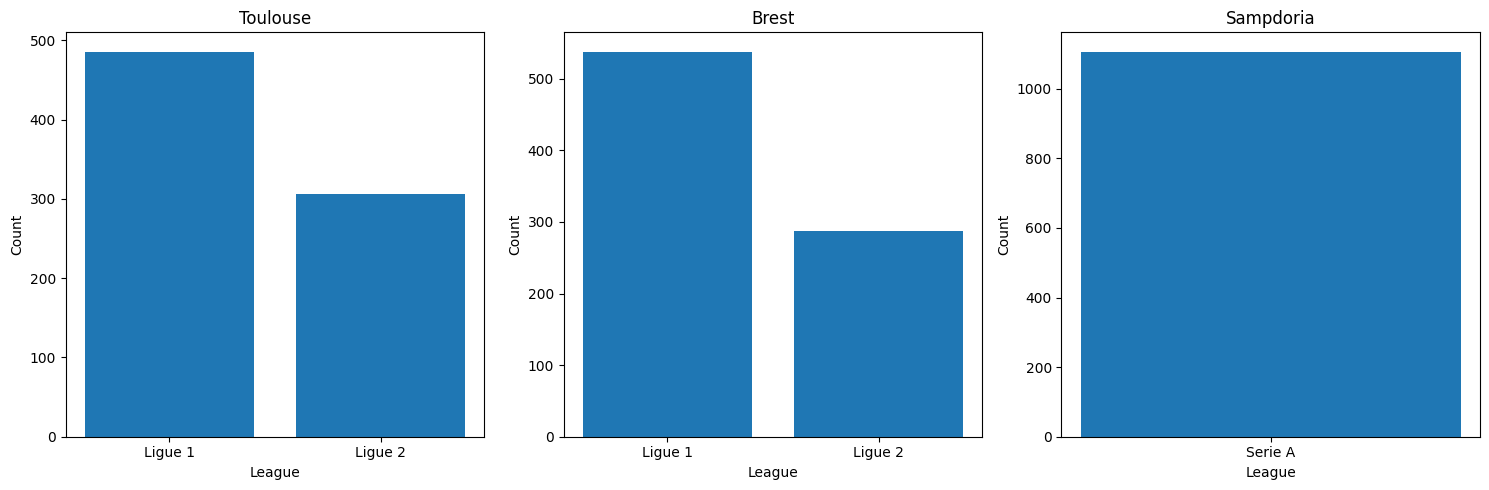

In [7]:
# Assuming train_home_player_statistics_df is already defined
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Added figsize for better visualization

for i, team in enumerate(train_home_player_statistics_df['TEAM_NAME'].unique()[:3]):
    # Filter dataframe for the current team
    team_df = train_home_player_statistics_df[train_home_player_statistics_df['TEAM_NAME'] == team]
    
    # Plot histogram for 'LEAGUE' column of the current team
    league_counts = team_df['LEAGUE'].value_counts()
    axs[i].bar(league_counts.index, league_counts.values)  
    axs[i].set_title(team)  
    axs[i].set_xlabel('League')  
    axs[i].set_ylabel('Count')  

plt.tight_layout() 
plt.show()


## On peut constater que les équipes appartiennent à plusieurs saisons différentes. On peut appercevori plusieurs ligues (divions) pour une seule équipe.

In [8]:
features_dict = {
    "offensive_features": [
        'TEAM_SHOTS_TOTAL',
        'TEAM_SHOTS_INSIDEBOX',
        'TEAM_SHOTS_OFF_TARGET',
        'TEAM_SHOTS_ON_TARGET',
        'TEAM_SHOTS_OUTSIDEBOX',
        'TEAM_PASSES',
        'TEAM_SUCCESSFUL_PASSES',
        'TEAM_CORNERS',
        'TEAM_ATTACKS',
        'TEAM_PENALTIES',
        'TEAM_DANGEROUS_ATTACKS',
        'TEAM_GOALS',
        'TEAM_SUCCESSFUL_PASSES_PERCENTAGE',
        'TEAM_BALL_POSSESSION',
    ],
    "defensive_features": [
        'TEAM_SAVES',
        'TEAM_BALL_SAFE',
        'TEAM_SUBSTITUTIONS',
    ],
    "disciplinary_features": [
        'TEAM_FOULS',
        'TEAM_YELLOWCARDS',
        'TEAM_REDCARDS',
        'TEAM_OFFSIDES',
    ],
    "general_game_results_features": [
        'TEAM_GAME_WON',
        'TEAM_GAME_DRAW',
        'TEAM_GAME_LOST',
        'TEAM_INJURIES',
    ],
}

# To access all features together as a single list, you can use a list comprehension
all_features = [feature for category in features_dict.values() for feature in category]

# Example of how to print all offensive features
print("Offensive Features:", features_dict["offensive_features"])


Offensive Features: ['TEAM_SHOTS_TOTAL', 'TEAM_SHOTS_INSIDEBOX', 'TEAM_SHOTS_OFF_TARGET', 'TEAM_SHOTS_ON_TARGET', 'TEAM_SHOTS_OUTSIDEBOX', 'TEAM_PASSES', 'TEAM_SUCCESSFUL_PASSES', 'TEAM_CORNERS', 'TEAM_ATTACKS', 'TEAM_PENALTIES', 'TEAM_DANGEROUS_ATTACKS', 'TEAM_GOALS', 'TEAM_SUCCESSFUL_PASSES_PERCENTAGE', 'TEAM_BALL_POSSESSION']


In [9]:
def aggregate_columns(df, base_names):
    column_groups = []
    for col in df.columns:
        for base_name in base_names:
            if base_name in col and col not in column_groups:
                column_groups.append(col)
    return column_groups


# Investigation 

In [10]:
def calculate_score(row):
    if (row[0] == 1) and (row[1] == 0):
        return 2  # win
    elif (row[0] == 0) and (row[1] == 1):
        return 1  # null
    elif (row[0] == 0) and (row[1] == 0):
        return 0  # lose
    
targ = train_scores.apply(lambda x: calculate_score(x), axis=1)


In [11]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

best_features = []

for key, list_variables in features_dict.items() :
    
    print(f"--------------------{key}--------------------------")
    cols = aggregate_columns(train_data, list_variables)
    mi_scores = mutual_info_classif(train_data.loc[:, cols], targ, discrete_features='auto')

    # Create a Series to view the scores alongside feature names for better readability
    mi_scores_series = pd.Series(mi_scores, index=cols)

    # Sort the series to see features with the highest mutual information first
    mi_scores_series = mi_scores_series.sort_values(ascending=False)
    print(mi_scores_series)
    selected_features = mi_scores_series[mi_scores_series > 0.018].index.tolist()

        # Add the selected features to the best_features list
    best_features.extend(selected_features)



--------------------offensive_features--------------------------
AWAY_TEAM_SHOTS_TOTAL_season_average            0.027971
AWAY_TEAM_PASSES_5_last_match_sum               0.024310
AWAY_TEAM_SHOTS_INSIDEBOX_season_average        0.024187
HOME_TEAM_CORNERS_season_sum                    0.022363
HOME_TEAM_BALL_POSSESSION_season_average        0.021974
                                                  ...   
HOME_TEAM_BALL_POSSESSION_season_std            0.000000
AWAY_TEAM_SHOTS_OUTSIDEBOX_season_sum           0.000000
AWAY_TEAM_DANGEROUS_ATTACKS_5_last_match_std    0.000000
AWAY_TEAM_SUCCESSFUL_PASSES_5_last_match_std    0.000000
AWAY_TEAM_PASSES_5_last_match_std               0.000000
Length: 160, dtype: float64
--------------------defensive_features--------------------------
AWAY_TEAM_SAVES_season_sum                      0.011630
HOME_TEAM_SAVES_season_average                  0.011590
AWAY_TEAM_SUBSTITUTIONS_5_last_match_average    0.011133
HOME_TEAM_BALL_SAFE_5_last_match_std        

In [12]:
from sklearn.feature_selection import f_classif
import pandas as pd
import numpy as np

# Example usage of f_classif to perform ANOVA
f_values, p_values = f_classif(train_home.drop(["LEAGUE", "TEAM_NAME"], axis=1), targ)

# Create a DataFrame to view F-values and P-values for each feature
anova_results = pd.DataFrame({
    'Feature': train_home.drop(["LEAGUE", "TEAM_NAME"], axis=1).columns,
    'F-value': f_values,
    'P-value': p_values
})

# Sort the results by P-value to see the most significant features first
anova_results_sorted = anova_results.sort_values(by='P-value')

# Select Best Features according to Mutual info classification Score

In [13]:
train_data_ = train_data.loc[:, best_features]
test_data_ = test_data.loc[:, best_features]

# Import Players Data

# Get Na columns 

In [14]:
from sklearn.preprocessing import MinMaxScaler

excluded_columns = ["LEAGUE", "TEAM_NAME","POSITION"]
train_away_player = train_away_player_statistics_df.drop(excluded_columns, axis = 1)
train_home_player = train_home_player_statistics_df.drop(excluded_columns, axis = 1)

In [15]:
excluded_test_columns = ["POSITION"]
test_away_player = test_away_player_statistics_df.drop(excluded_test_columns, axis = 1)
test_home_player = test_home_player_statistics_df.drop(excluded_test_columns, axis = 1)

# Drop Columns with more than 50% of NaNs

In [16]:
col_to_drop_away = [column for column in train_away_player.columns if train_away_player[column].isna().sum()/ len(train_away_player) > 0.5]
train_away_player = train_away_player.drop(col_to_drop_away, axis = 1)
col_to_drop_home =  [column for column in train_home_player.columns if train_home_player[column].isna().sum()/ len(train_home_player) > 0.5]
train_home_player = train_home_player.drop(col_to_drop_home, axis = 1)

In [17]:
test_away_player = test_away_player.drop(col_to_drop_away, axis = 1)
test_home_player = test_home_player.drop(col_to_drop_home, axis = 1)

# Fill player NaNs with match average performance

In [18]:
import pandas as pd
import numpy as np


def fill_na_function_player_optimized(df):
    # Identifying columns with NaN values
    nan_cols = df.columns[df.isna().any()].tolist()
    
    # Calculate means for each group identified by 'ID', excluding 'PLAYER_NAME' from the mean calculation
    means = df.drop(["PLAYER_NAME"],axis=1).groupby('ID').transform(lambda x: x.fillna(x.mean()).fillna(0))

    # Fill NaN values in the original dataframe
    df[nan_cols] = df[nan_cols].fillna(means)

    # Recheck for any remaining NaNs
    recheck = df.columns[df.isna().any()].tolist()
    if not recheck:
        print("All NaNs cleaned!")
    else:
        print(f"There are {len(recheck)} columns not cleaned!")

    return df


# Assuming `train_home_player` and `train_away_player` are defined
train_home_player_ = fill_na_function_player_optimized(train_home_player)
train_away_player_ = fill_na_function_player_optimized(train_away_player)

All NaNs cleaned!
All NaNs cleaned!


In [19]:
test_home_player_ = test_home_player.fillna(0)
test_away_player_ = test_away_player.fillna(0)

# Construct team graph for each match 

In [20]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.5 MB/s eta 0:00:00


# Devide train & validation Data

In [21]:
from torch.utils.data import random_split

total_size = len(train_data_)

# Define the ratio for splitting the dataset into training and validation
train_ratio = 0.8
# Calculate the sizes of each subset
train_size = int(train_ratio * total_size)
validate_size = total_size - train_size
# Generate indices: torch.arange() is similar to Python's range but returns a tensor
indices = np.arange(total_size)
# Split the indices into training and validation sets
train_indices, validate_indices = random_split(indices, [train_size, validate_size])


In [22]:
train_teams = train_data_.iloc[list(train_indices), :]
val_teams= train_data_.iloc[list(validate_indices), :]

train_home_player = train_home_player_.drop(["PLAYER_NAME"],axis=1)[train_home_player_.index.isin(list(train_indices))]
val_home_player = train_home_player_.drop(["PLAYER_NAME"],axis=1)[train_home_player_.index.isin(list(validate_indices))]

train_away_player = train_away_player_.drop(["PLAYER_NAME"],axis=1)[train_away_player_.index.isin(list(train_indices))]
val_away_player =  train_away_player_.drop(["PLAYER_NAME"],axis=1)[train_away_player_.index.isin(list(validate_indices))]

y_train = train_scores.iloc[list(train_indices), :]
y_val = train_scores.iloc[list(validate_indices), :]

# Scale the data

In [23]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Initialize the StandardScaler
scaler_teams = MinMaxScaler()
scaler_home_player = MinMaxScaler()
scaler_away_player = MinMaxScaler()

# Fit on training data and transform both training and validation data
# For train_teams and val_teams
train_teams_scaled = scaler_teams.fit_transform(train_teams)
val_teams_scaled = scaler_teams.transform(val_teams)

# For train_home_player and val_home_player
train_home_player_scaled = scaler_home_player.fit_transform(train_home_player)
val_home_player_scaled = scaler_home_player.transform(val_home_player)

# For train_away_player and val_away_player
train_away_player_scaled = scaler_away_player.fit_transform(train_away_player)
val_away_player_scaled = scaler_away_player.transform(val_away_player)

# Optionally, convert the scaled arrays back to DataFrames
# This step is useful if you need DataFrame functionalities later on
train_teams_scaled = pd.DataFrame(train_teams_scaled, index=train_teams.index, columns=train_teams.columns)
val_teams_scaled = pd.DataFrame(val_teams_scaled, index=val_teams.index, columns=val_teams.columns)

train_home_player_scaled = pd.DataFrame(train_home_player_scaled, index=train_home_player.index, columns=train_home_player.columns)
val_home_player_scaled = pd.DataFrame(val_home_player_scaled, index=val_home_player.index, columns=val_home_player.columns)

train_away_player_scaled = pd.DataFrame(train_away_player_scaled, index=train_away_player.index, columns=train_away_player.columns)
val_away_player_scaled = pd.DataFrame(val_away_player_scaled, index=val_away_player.index, columns=val_away_player.columns)

# Sort the indexes of the scaled DataFrames
train_teams_scaled = train_teams_scaled.sort_index()
val_teams_scaled = val_teams_scaled.sort_index()

train_home_player_scaled = train_home_player_scaled.sort_index()
val_home_player_scaled = val_home_player_scaled.sort_index()

train_away_player_scaled = train_away_player_scaled.sort_index()
val_away_player_scaled = val_away_player_scaled.sort_index()

y_train = y_train.sort_index()
y_val = y_val.sort_index()

In [24]:
test_teams_scaled = scaler_teams.transform(test_data_)
test_home_player_scaled = scaler_home_player.transform(test_home_player_)
test_away_player_scaled = scaler_away_player.transform(test_away_player_)
test_teams_scaled = pd.DataFrame(test_teams_scaled, index=test_data_.index, columns=test_data_.columns)
test_home_player_scaled = pd.DataFrame(test_home_player_scaled, index=test_home_player_.index, columns=test_home_player_.columns)
test_away_player_scaled = pd.DataFrame(test_away_player_scaled, index=test_away_player_.index, columns=test_away_player_.columns)

In [25]:
import torch
from torch_geometric.data import Data
from torch.utils.data import TensorDataset
from torch_geometric.data import DataLoader
from torch.utils.data import Dataset

def make_graph(df, main_df) :
        edge_index  = []
        x=[]
        weights = []
        matches = df.index.unique().sort_values()
        for match in matches :
            edges= []
            weights_match= []
            team_players = df.iloc[df.index == match, : ].reset_index()
            positions = main_df.iloc[main_df.index == match, : ]["POSITION"].values
            for i in range(len(team_players)) :
                for j in range(i+1, len(team_players)) :                         
                        min_played_together = min(team_players.loc[i, "PLAYER_MINUTES_PLAYED_5_last_match_sum"], team_players.loc[j, "PLAYER_MINUTES_PLAYED_5_last_match_sum"])
                        if min_played_together != 0 :
                            weights_match.append(min_played_together)
                            weights_match.append(min_played_together)
                            edges.append([i,j])
                            edges.append([j,i])
                            
                        passes = max(team_players.loc[i, "PLAYER_PASSES_5_last_match_average"],team_players.loc[j, "PLAYER_PASSES_5_last_match_average"])
                        if passes != 0:
                            weights_match.append(passes)
                            weights_match.append(passes)
                            edges.append([i, j])
                            edges.append([j, i])

                        position_i = positions[i]
                        position_j = positions[j]
                        
                        # Consider specific features for each position
                        if position_i == "goalkeeper" and position_j == "goalkeeper":
                            pass  # No additional edges for goalkeeper vs goalkeeper
                        elif position_i == "defender" and position_j == "defender":
                            assists_i = team_players.loc[i, "PLAYER_ACCURATE_PASSES_5_last_match_average"]
                            clearances_j = team_players.loc[j, "PLAYER_CLEARANCES_5_last_match_average"]
                            if assists_i != 0:
                                edges.append([i, j])
                                weights_match.append(assists_i)
                            if clearances_j != 0:
                                edges.append([j, i])
                                weights_match.append(clearances_j)

                        elif position_i == "midfielder" and position_j == "midfielder":
                            # Consider specific features for midfielders
                            accurate_passes_i = team_players.loc[i, "PLAYER_ACCURATE_PASSES_5_last_match_average"]
                            if accurate_passes_i != 0:
                                edges.append([i, j])
                                weights_match.append(accurate_passes_i)


                        elif position_i == "attacker" and position_j == "attacker":
                            # Consider specific features for attackers
                            goals_i = team_players.loc[i, "PLAYER_GOALS_5_last_match_average"]
                            shots_on_target_j = team_players.loc[j, "PLAYER_SHOTS_TOTAL_5_last_match_average"]
                            if goals_i != 0 and shots_on_target_j != 0:  # Example threshold for goals and shots on target
                                edges.append([i, j])
                                edges.append([j, i])
                                weights_match.append(goals_i)
                                weights_match.append(shots_on_target_j)
                        elif position_i == "defender" and position_j == "midfielder":
                                interceptions_i = team_players.loc[i, "PLAYER_INTERCEPTIONS_5_last_match_average"]
                                key_passes_j = team_players.loc[j, "PLAYER_KEY_PASSES_5_last_match_average"]
                                if interceptions_i != 0 and key_passes_j != 0:
                                    edges.append([i, j])
                                    edges.append([j, i])
                                    weights_match.append(interceptions_i)
                                    weights_match.append(key_passes_j)
                        elif position_i == "midfielder" and position_j == "attacker":
                            successful_dribbles_i = team_players.loc[i, "PLAYER_ASSISTS_5_last_match_average"]
                            shots_total_j = team_players.loc[i, "PLAYER_KEY_PASSES_5_last_match_average"]
                            if successful_dribbles_i != 0 and shots_total_j != 0:
                                edges.append([i, j])
                                edges.append([j, i])
                                weights_match.append(successful_dribbles_i)
                                weights_match.append(shots_total_j)
            
            # Convert edge indices and weights to  tensors and append to lists
            edge_index.append(torch.tensor(edges, dtype=torch.long).t().contiguous())
            weights.append(torch.tensor(weights_match, dtype=torch.float))
            feature_columns = [col for col in team_players.columns if col not in ['MATCH_ID', 'ID', 'LEAGUE', 'TEAM_NAME', 'POSITION', 'PLAYER_NAME']]
            x.append(torch.tensor(team_players[feature_columns].values, dtype=torch.float))  
    
        return x,edge_index, weights


# Form train and validation data 

In [26]:
class CombinedDataset(Dataset):
    def __init__(self, data_home, data_away, club_data_tensor, targets_tensor):
        self.data_home = data_home
        self.data_away = data_away
        self.club_data = club_data_tensor
        self.targets = targets_tensor

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        home_data = self.data_home[idx]
        away_data = self.data_away[idx]
        club_data = self.club_data[idx]
        target = self.targets[idx]
        return home_data, away_data, club_data, target

# Train Data

In [27]:
x_home, edges_home, weights_home = make_graph(train_home_player_scaled, train_home_player_statistics_df)
x_away, edges_away, weights_away = make_graph(train_away_player_scaled, train_away_player_statistics_df)

data_away = []
data_home =[]
club_data_list = []
targets_list = []

for i,match in enumerate(train_teams_scaled.index) :
   club_features = torch.tensor(train_teams_scaled.loc[match, :].values, dtype=torch.float)
   match_target = torch.tensor(y_train.loc[match, :].values, dtype=torch.float)
   data_home.append(Data(x=x_home[i], edge_index=edges_home[i], edge_attr = weights_home[i].unsqueeze(1)))
   data_away.append(Data(x=x_away[i], edge_index=edges_away[i], edge_attr = weights_away[i].unsqueeze(1)))
   club_data_list.append(club_features)
   targets_list.append(match_target)
    

club_data_tensor = torch.stack(club_data_list)
targets_tensor = torch.stack(targets_list)

dataset_train = CombinedDataset(data_home, data_away, club_data_tensor, targets_tensor)

# Validation Data

In [28]:
x_home, edges_home, weights_home = make_graph(val_home_player_scaled, train_home_player_statistics_df)
x_away, edges_away, weights_away = make_graph(val_away_player_scaled, train_away_player_statistics_df)

data_away = []
data_home =[]
club_data_list = []
targets_list = []

for i,match in enumerate(val_teams_scaled.index) :
   club_features = torch.tensor(val_teams_scaled.loc[match, :].values, dtype=torch.float)
   match_target = torch.tensor(y_val.loc[match, :].values, dtype=torch.float)
   data_home.append(Data(x=x_home[i], edge_index=edges_home[i], edge_attr = weights_home[i].unsqueeze(1)))
   data_away.append(Data(x=x_away[i], edge_index=edges_away[i], edge_attr = weights_away[i].unsqueeze(1)))
   club_data_list.append(club_features)
   targets_list.append(match_target)
    

club_data_tensor = torch.stack(club_data_list)
targets_tensor = torch.stack(targets_list)

val_dataset = CombinedDataset(data_home, data_away, club_data_tensor, targets_tensor)

In [29]:
# Test Data
x_home, edges_home, weights_home = make_graph(test_home_player_scaled, test_home_player_statistics_df)
x_away, edges_away, weights_away = make_graph(test_away_player_scaled, test_away_player_statistics_df)

data_away = []
data_home =[]
club_data_list = []

for i,match in enumerate(test_teams_scaled.index) :
   club_features = torch.tensor(test_teams_scaled.loc[match, :].values, dtype=torch.float)
   data_home.append(Data(x=x_home[i], edge_index=edges_home[i], edge_attr = weights_home[i].unsqueeze(1)))
   data_away.append(Data(x=x_away[i], edge_index=edges_away[i], edge_attr = weights_away[i].unsqueeze(1)))
   club_data_list.append(club_features)
    

club_data_tensor = torch.stack(club_data_list)

test_dataset = CombinedDataset(data_home, data_away, club_data_tensor, torch.zeros(25368))

In [30]:
train_loader = DataLoader(dataset_train, batch_size=128, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Model 

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# GAT Model

In [32]:
import torch.nn.functional as F
from torch import nn
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import GCNConv, GATv2Conv

class Football_GAT_model(nn.Module):
    def __init__(self, num_node_features, nout, nhid, graph_hidden_channels, club_caracteristics_size, dropout=0.3):
        super(Football_GAT_model, self).__init__()
        
        self.drop = nn.Dropout(p=dropout)

        self.conv1_home = GATv2Conv(num_node_features, graph_hidden_channels, heads=4, concat=True)
        self.conv3_home = GATv2Conv(graph_hidden_channels*4, graph_hidden_channels, heads=6, concat=False)  # Outputs are averaged
        
        self.conv1_away = GATv2Conv(num_node_features, graph_hidden_channels, heads=4, concat=True)
        self.conv3_away = GATv2Conv(graph_hidden_channels*4, graph_hidden_channels, heads=6, concat=False)  # Outputs are averaged
        
        # Linear layers for the concatenated features
        self.hidden1 = nn.Linear(graph_hidden_channels * 2 + club_caracteristics_size, nhid)
        self.hidden2 = nn.Linear(nhid, nout)
        
        self.elu = nn.ELU()

    def forward(self, home_batch, away_batch, club_batch):
        # Home team convolution
        
        x_home = self.conv1_home(home_batch.x, home_batch.edge_index).relu()
        x_home = self.conv3_home(x_home, home_batch.edge_index).relu()

        readout_home = global_mean_pool(x_home, home_batch.batch)  # [batch_size, graph_hidden_channels]
        
        # Away team convolution
        x_away = self.conv1_away(away_batch.x, away_batch.edge_index).relu()
        x_away = self.conv3_away(x_away, away_batch.edge_index).relu()
        readout_away = global_mean_pool(x_away, away_batch.batch)  # [batch_size, graph_hidden_channels]
        
        # Club characteristics
        club = club_batch

        # Concatenation of home and away readouts (graph level representations) along with club characteristics
        concatenated_team = torch.cat([readout_home, readout_away, club], dim=1)  # [batch_size, graph_hidden_channels * 2 + club_caracteristics_size]
        
        # Pass through the fully connected layers
        z = self.hidden1(concatenated_team).relu()
        z = self.hidden2(z)
  
        return z, concatenated_team

In [38]:
model = Football_GAT_model(num_node_features = 272,nout = 3, nhid=256,graph_hidden_channels=600, club_caracteristics_size = 16) 
model.to(device)

Football_GAT_model(
  (drop): Dropout(p=0.3, inplace=False)
  (conv1_home): GATv2Conv(272, 600, heads=4)
  (conv3_home): GATv2Conv(2400, 600, heads=6)
  (conv1_away): GATv2Conv(272, 600, heads=4)
  (conv3_away): GATv2Conv(2400, 600, heads=6)
  (hidden1): Linear(in_features=1216, out_features=256, bias=True)
  (hidden2): Linear(in_features=256, out_features=3, bias=True)
  (elu): ELU(alpha=1.0)
)

In [39]:
from torch.optim.lr_scheduler import StepLR


# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = torch.optim.SGD(model.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)

In [40]:
nb_epochs = 10  # N of epochs
train_dataset_embeddings = []
valid_dataset_embeddings = []
train_targets = []
valid_targets = []
logits_train = []

for epoch in range(nb_epochs):
    print(f'-----EPOCH {epoch+1}-----')
    
    # Training phase
    model.train()
    total_loss = 0
    for data_home, data_away, club_data_tensor, targets_tensor in train_loader:
        logits, batch_embeddings = model(data_home.to(device), 
                       data_away.to(device), 
                       club_data_tensor.to(device))
        
        if epoch == nb_epochs -1:
            train_dataset_embeddings.append(batch_embeddings.detach().cpu())
            train_targets.append(targets_tensor)
            logits_train.append(logits)
        
        current_loss = loss_fn(logits, targets_tensor.to(device))
        
        optimizer.zero_grad()
        current_loss.backward()
        optimizer.step()
        
        total_loss += current_loss.item()

    print(f'Training Loss: {total_loss / len(train_loader)}')
    
    # Validation phase
    model.eval()
    total_val_loss = 0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for data_home, data_away, club_data_tensor, targets_tensor in val_loader:
            logits, val_batch_embeddings = model(data_home.to(device), 
                           data_away.to(device), 
                           club_data_tensor.to(device))
            val_loss = loss_fn(logits, targets_tensor.to(device))
            total_val_loss += val_loss.item()
            
            if epoch == nb_epochs -1:
                valid_dataset_embeddings.append(val_batch_embeddings.detach().cpu())
                valid_targets.append(targets_tensor)

            # Calculate accuracy
            predicted_labels = torch.argmax(logits.detach().cpu(), 1)
            targets_tensor = torch.argmax(targets_tensor, 1)
            correct_predictions += (predicted_labels == targets_tensor).sum().item()
            total_predictions += targets_tensor.size(0)
            

    validation_accuracy = correct_predictions / total_predictions
    print(f'Validation Loss: {total_val_loss / len(val_loader)}')
    print(f'Validation Accuracy: {validation_accuracy * 100:.2f}%')
    
# Concatenate the embeddings into a single tensor
train_dataset_embeddings = torch.cat(train_dataset_embeddings, dim=0)
valid_dataset_embeddings = torch.cat(valid_dataset_embeddings, dim=0)
train_targets = torch.cat(train_targets, dim=0)
valid_targets = torch.cat(valid_targets, dim=0)
logits_train = torch.cat(logits_train, dim=0)

-----EPOCH 1-----
Training Loss: 1.0720249956304377
Validation Loss: 1.054482913017273
Validation Accuracy: 43.64%
-----EPOCH 2-----
Training Loss: 1.0450191768732937
Validation Loss: 1.0338347554206848
Validation Accuracy: 47.95%
-----EPOCH 3-----
Training Loss: 1.0257686376571655
Validation Loss: 1.024758180975914
Validation Accuracy: 48.88%
-----EPOCH 4-----
Training Loss: 1.019063732840798
Validation Loss: 1.0241890996694565
Validation Accuracy: 49.49%
-----EPOCH 5-----
Training Loss: 1.0174154283164383
Validation Loss: 1.0245983958244325
Validation Accuracy: 49.78%
-----EPOCH 6-----
Training Loss: 1.0166714601702505
Validation Loss: 1.0248852223157883
Validation Accuracy: 49.70%
-----EPOCH 7-----
Training Loss: 1.0161799254355492
Validation Loss: 1.0250722289085388
Validation Accuracy: 49.57%
-----EPOCH 8-----
Training Loss: 1.0158190115705712
Validation Loss: 1.0251942038536073
Validation Accuracy: 49.57%
-----EPOCH 9-----
Training Loss: 1.0155191460213104
Validation Loss: 1.0252

In [41]:
model.eval()  

predictions = []  
test_dataset_embeddings = []


with torch.no_grad():  
    for data_home, data_away, club_data_tensor, _ in test_loader:
        # Generate predictions
        test_logits, test_embeddings = model(data_home.to(device), 
                             data_away.to(device), 
                             club_data_tensor.to(device))
        
        predictions.append(test_logits.cpu())
        test_dataset_embeddings.append(test_embeddings.detach().cpu())


# Concatenate all predictions across batches
all_predictions = torch.cat(predictions, dim=0)
_, indices = torch.max(all_predictions, 1)

# Convert these indices into one-hot encoded format
one_hot = torch.nn.functional.one_hot(indices, num_classes=3)

predictions_numpy = one_hot.numpy()
predictions_df = pd.DataFrame(predictions_numpy, columns=['HOME_WINS', 'DRAW', 'AWAY_WINS'])
predictions_df.index = test_data.index
submission = predictions_df.reset_index()
submission.to_csv('/kaggle/working/submission_GAT.csv', index=False)

test_dataset_embeddings = torch.cat(test_dataset_embeddings, dim=0)

In [42]:
# Convert tensor to a NumPy array
train_dataset_embeddings_array = train_dataset_embeddings.numpy()
valid_dataset_embeddings_array = valid_dataset_embeddings.numpy()
test_dataset_embeddings_array = test_dataset_embeddings.numpy()
train_targets_array = train_targets.numpy()
valid_targets_array = valid_targets.numpy()


# Convert NumPy array to a DataFrame
df_train_embeddings = pd.DataFrame(train_dataset_embeddings_array)
df_valid_embeddings = pd.DataFrame(valid_dataset_embeddings_array)
df_test_embeddings = pd.DataFrame(test_dataset_embeddings_array)
df_train_targets = pd.DataFrame(train_targets_array)
df_valid_targets = pd.DataFrame(valid_targets_array)

# Save DataFrame to CSV
df_train_embeddings.to_csv('df_train_embeddings.csv', index=False)
df_valid_embeddings.to_csv('df_valid_embeddings.csv', index=False)
df_test_embeddings.to_csv('df_test_embeddings.csv', index=False)
df_train_targets.to_csv('df_train_targets.csv', index=False)
df_valid_targets.to_csv('df_valid_targets.csv', index=False)

In [43]:
from catboost import CatBoostClassifier, Pool
import pandas as pd

# Assuming y_train is a pandas DataFrame with three dimensions
y_train_dim1 = y_train.iloc[:, 0]  # First dimension
y_train_dim2 = y_train.iloc[:, 1]  # Second dimension
y_train_dim3 = y_train.iloc[:, 2]  # Third dimension

y_val_dim1 = y_val.iloc[:, 0]  # First dimension
y_val_dim2 = y_val.iloc[:, 1]  # Second dimension
y_val_dim3 = y_val.iloc[:, 2]  # Third dimension

# Separate features and target variable for the last y_train.shape[0] rows
X_train = df_train_embeddings.tail(y_train.shape[0])

y_train_list = [y_train_dim1, y_train_dim2, y_train_dim3]
y_val_list = [y_val_dim1, y_val_dim2, y_val_dim3]

# Define CatBoost models for each dimension
models = []
for d in range(3):
    # Define CatBoost model
    model = CatBoostClassifier(iterations=1000,  # Number of trees
                               learning_rate=0.1,
                               depth=6,
                               loss_function='Logloss',  # Use Logloss for classification
                               eval_metric='AUC',  # Evaluation metric
                               random_seed=42)
    
    # Train the model
    model.fit(X_train, y_train_list[d], eval_set=(df_valid_embeddings.tail(y_val.shape[0]), y_val_list[d]))
    
    # Append the trained model to the list
    models.append(model)

0:	test: 0.6096038	best: 0.6096038 (0)	total: 271ms	remaining: 4m 30s
1:	test: 0.6358666	best: 0.6358666 (1)	total: 435ms	remaining: 3m 36s
2:	test: 0.6367235	best: 0.6367235 (2)	total: 602ms	remaining: 3m 20s
3:	test: 0.6443206	best: 0.6443206 (3)	total: 766ms	remaining: 3m 10s
4:	test: 0.6447909	best: 0.6447909 (4)	total: 930ms	remaining: 3m 5s
5:	test: 0.6475402	best: 0.6475402 (5)	total: 1.09s	remaining: 3m
6:	test: 0.6480544	best: 0.6480544 (6)	total: 1.25s	remaining: 2m 57s
7:	test: 0.6475748	best: 0.6480544 (6)	total: 1.42s	remaining: 2m 55s
8:	test: 0.6471196	best: 0.6480544 (6)	total: 1.58s	remaining: 2m 54s
9:	test: 0.6471562	best: 0.6480544 (6)	total: 1.75s	remaining: 2m 52s
10:	test: 0.6458532	best: 0.6480544 (6)	total: 1.91s	remaining: 2m 51s
11:	test: 0.6453152	best: 0.6480544 (6)	total: 2.08s	remaining: 2m 51s
12:	test: 0.6458421	best: 0.6480544 (6)	total: 2.25s	remaining: 2m 51s
13:	test: 0.6464054	best: 0.6480544 (6)	total: 2.42s	remaining: 2m 50s
14:	test: 0.6461093	b

In [44]:
# Generate predictions for each dimension
predictions_dim1 = models[0].predict_proba(df_test_embeddings)[:, 1]  # Probability of class 1
predictions_dim2 = models[1].predict_proba(df_test_embeddings)[:, 1]  # Probability of class 1
predictions_dim3 = models[2].predict_proba(df_test_embeddings)[:, 1]  # Probability of class 1

# Combine the predictions into a 3-dimensional array
predictions_3d = np.column_stack((predictions_dim1, predictions_dim2, predictions_dim3))

In [45]:
train_targets = train_targets.cpu()
logits_train = logits_train.cpu()

In [103]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


# Calculate residuals for each dimension
residuals_dim1 = train_targets[:, 0] - logits_train[:, 0]
residuals_dim2 = train_targets[:, 1] - logits_train[:, 1]
residuals_dim3 = train_targets[:, 2] - logits_train[:, 2]

# Split the data into training and validation sets
X_train_res, X_val_res, y_train_res_dim1, y_val_res_dim1 = train_test_split(df_train_embeddings, residuals_dim1.detach().numpy(), test_size=0.2, random_state=42)
_, _, y_train_res_dim2, y_val_res_dim2 = train_test_split(df_train_embeddings, residuals_dim2.detach().numpy(), test_size=0.2, random_state=42)
_, _, y_train_res_dim3, y_val_res_dim3 = train_test_split(df_train_embeddings, residuals_dim3.detach().numpy(), test_size=0.2, random_state=42)

# Train CatBoost regression models for each dimension
catboost_models = []
for y_train_res_dim, y_val_res_dim in [(y_train_res_dim1, y_val_res_dim1),
                                       (y_train_res_dim2, y_val_res_dim2),
                                       (y_train_res_dim3, y_val_res_dim3)]:
    model = CatBoostRegressor(iterations=1000,  # Number of trees
                              learning_rate=0.01,
                              depth=6,
                              loss_function='RMSE',  # Use RMSE for regression
                              eval_metric='RMSE',  # Evaluation metric
                              random_seed=42)
    model.fit(X_train_res, y_train_res_dim, eval_set=(X_val_res, y_val_res_dim), verbose=False)
    catboost_models.append(model)

In [107]:
# Train LightGBM regression models for each dimension
lgb_models = []
for y_train_res_dim, y_val_res_dim in [(y_train_res_dim1, y_val_res_dim1),
                                       (y_train_res_dim2, y_val_res_dim2),
                                       (y_train_res_dim3, y_val_res_dim3)]:
    
    lgb = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=100,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )
    
    lgb.fit(X_train_res, y_train_res_dim, eval_set=(X_val_res, y_val_res_dim))
    lgb_models.append(lgb)

In [109]:
from xgboost import XGBRegressor

# Train XGBoost regression models for each dimension
xgb_models = []
for y_train_res_dim, y_val_res_dim in [(y_train_res_dim1, y_val_res_dim1),
                                       (y_train_res_dim2, y_val_res_dim2),
                                       (y_train_res_dim3, y_val_res_dim3)]:
    
    xgb = XGBRegressor(learning_rate=0.01,n_estimators=500,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)
    
    xgb.fit(X_train_res, y_train_res_dim)
    xgb_models.append(xgb)

In [163]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

# Stack CatBoost, LightGBM, and XGBoost models
stacked_models = []
dim = 0
for catboost_model, lgb_model, xgb_model in zip(catboost_models, lgb_models, xgb_models):
    
    # Generate predictions using CatBoost models
    catboost_predictions = catboost_model.predict(df_train_embeddings)

    # Generate predictions using LightGBM models
    lgb_predictions = lgb_model.predict(df_train_embeddings)

    # Generate predictions using CNN model
    xgb_predictions = xgb_model.predict(df_train_embeddings)

    # Combine predictions with original features
    combined_predictions = np.column_stack((catboost_predictions, lgb_predictions, xgb_predictions))

    # Initialize meta-regressor
    meta_regressor = LinearRegression()

    # Stack base models and train meta-regressor
    stacked_model = StackingRegressor(
        estimators= [("CatBoost",model),("LightGBM",lgb),("XGBoost",xgb)],
        final_estimator=meta_regressor
    )

    # Fit stacked model
    y_stacked = residuals[dim]
    stacked_model.fit(combined_predictions, y_stacked)  # Adjust train_targets for each dimension
    stacked_models.append(stacked_model)
    dim += 1

0:	learn: 0.5520494	total: 2.18ms	remaining: 2.17s
1:	learn: 0.5502074	total: 4.46ms	remaining: 2.22s
2:	learn: 0.5483503	total: 6.29ms	remaining: 2.09s
3:	learn: 0.5465231	total: 8.09ms	remaining: 2.01s
4:	learn: 0.5447393	total: 10.1ms	remaining: 2.02s
5:	learn: 0.5430197	total: 11.9ms	remaining: 1.97s
6:	learn: 0.5412510	total: 13.7ms	remaining: 1.95s
7:	learn: 0.5395260	total: 15.8ms	remaining: 1.95s
8:	learn: 0.5378058	total: 17.6ms	remaining: 1.94s
9:	learn: 0.5362434	total: 19.4ms	remaining: 1.92s
10:	learn: 0.5345690	total: 21.3ms	remaining: 1.91s
11:	learn: 0.5329221	total: 23.1ms	remaining: 1.9s
12:	learn: 0.5313301	total: 24.9ms	remaining: 1.89s
13:	learn: 0.5298017	total: 26.8ms	remaining: 1.89s
14:	learn: 0.5282655	total: 28.9ms	remaining: 1.9s
15:	learn: 0.5267447	total: 30.9ms	remaining: 1.9s
16:	learn: 0.5252827	total: 32.7ms	remaining: 1.89s
17:	learn: 0.5237959	total: 34.6ms	remaining: 1.89s
18:	learn: 0.5224019	total: 36.4ms	remaining: 1.88s
19:	learn: 0.5209853	tota

In [167]:
# Initialize a list to store stacking predictions for each dimension
stacking_predictions = []

dim = 0
# Generate predictions using the stacking regressors for each dimension
for catboost_model, lgb_model, xgb_model in zip(catboost_models, lgb_models, xgb_models):
    
    # Generate predictions using CatBoost models
    catboost_predictions = catboost_model.predict(df_test_embeddings)

    # Generate predictions using LightGBM models
    lgb_predictions = lgb_model.predict(df_test_embeddings)

    # Generate predictions using CNN model
    xgb_predictions = xgb_model.predict(df_test_embeddings)

    # Combine predictions with original features
    combined_predictions = np.column_stack((catboost_predictions, lgb_predictions, xgb_predictions))
    stacking_predictions_dim = stacked_models[dim].predict(combined_predictions)
    stacking_predictions.append(stacking_predictions_dim)
    dim += 1

In [176]:
# Initialize a list to store the summed predictions for each dimension
summed_predictions = []

# Iterate over each dimension
for dim in range(predictions_3d.shape[1]):
    # Sum the predictions for the current dimension
    summed_dim = predictions_3d[:, dim] + stacking_predictions[dim]
    summed_predictions.append(summed_dim)

In [178]:
# Convert the list of summed predictions to a numpy array
summed_predictions_array = np.column_stack(summed_predictions)

# Find the index of the maximum value in each row
max_indices = np.argmax(summed_predictions_array, axis=1)

# Initialize a new array with zeros
result_array = np.zeros_like(summed_predictions_array)

# Set 1 to the maximum value in each row
result_array[np.arange(len(summed_predictions_array)), max_indices] = 1

In [181]:
predictions_df = pd.DataFrame(result_array, columns=['HOME_WINS', 'DRAW', 'AWAY_WINS'])
predictions_df.index = test_data.index
submission = predictions_df.reset_index()
submission.to_csv('/kaggle/working/submission_final.csv', index=False)